In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from simcodes.fitters import ExtendedLS
from gatspy.periodic import LombScargleMultiband

In [2]:
### Integrating with period determination
library=pd.read_csv('simcodes/ZTF_VS_all_formatted.csv',index_col=0)
library['unique_filts_']=library['unique_filts_'].apply(lambda x:list(map(eval,x[1:-1].split(' '))))
library['ymean_by_filt_']=library['ymean_by_filt_'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))
library['theta']=library['theta'].apply(lambda x:np.array([float(k) for k in x[1:-1].split(' ') if len(k)>0]))

In [75]:
def determinePeriod(row,missingData:bool=True,plot:bool=True)->float:
    """
    Determine period for a simulated light curve 'observed' with a given cadence. Credits for the simcode and 
    LCs to Kresimir Tisanic
    """
    tt=[]
    tt.append(np.linspace(0,row['_best_period']*5,60))
    if missingData==True:
        for i in range(0,int(len(tt[0])*0.6),3):
            tt.append(np.delete(tt[0],np.array(range(i,i+int(len(tt[0])*0.3)))))
    periodMin=row['_best_period']*0.5
    periodMax=row['_best_period']*1.5
    pp={}
    for i,t in enumerate(tt):
        filts=[row['unique_filts_'][0]]*len(t)
        ext=ExtendedLS(fit_period=True,optimizer_kwds=dict(quiet=True),Nterms_base=row['Nterms'])
        ext.import_parameters(row)
        mags = ext.predict(t=t,filts=filts)
        magErrs=0.1*mags
        ext.optimizer.period_range = (periodMin, periodMax)
        p=ext.fit(t,mags,magErrs,filts).best_period
        if plot==True:
            fig=plt.figure(figsize=(5,5))
            subplot=fig.add_subplot(1,1,1)
            subplot.scatter((t%p)/p,mags,s=1)
        pp['detectedPeriod_'+str(i)]=p
    return pp

In [76]:
libraryShort=library.iloc[0:10]

/tmp/ipykernel_500592/283777788.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(5,5))


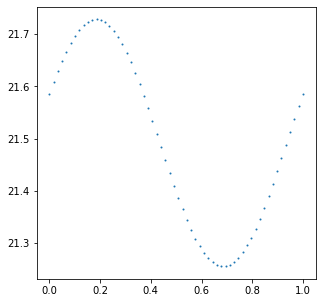

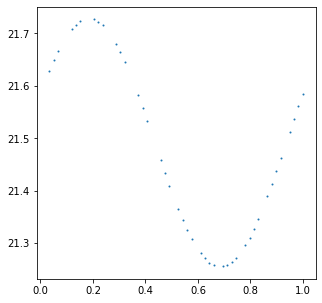

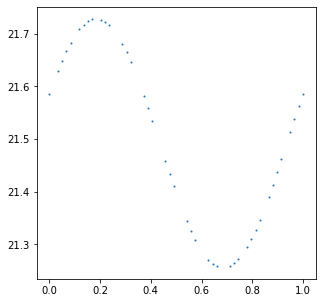

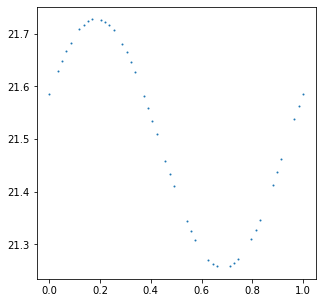

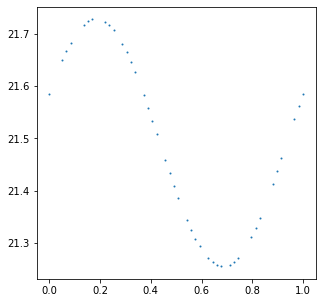

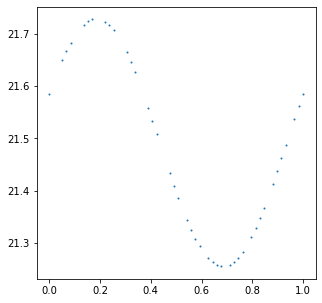

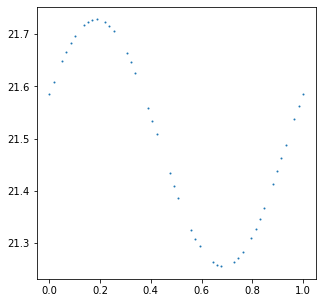

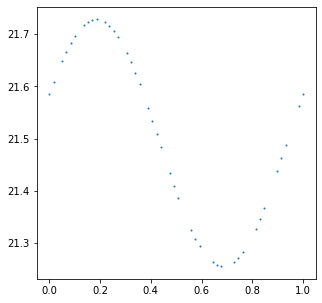

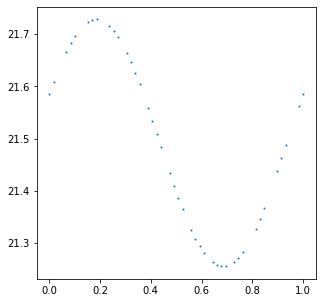

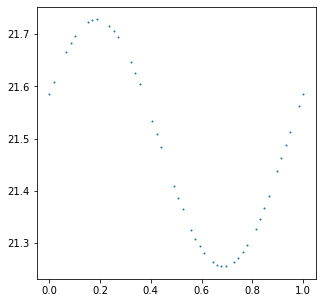

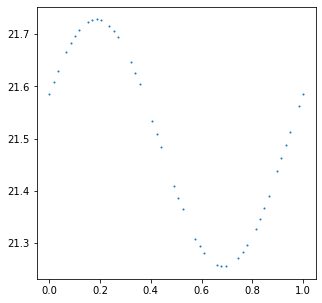

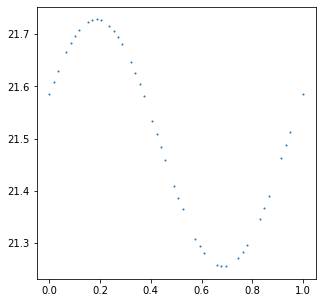

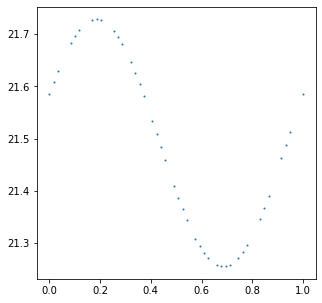

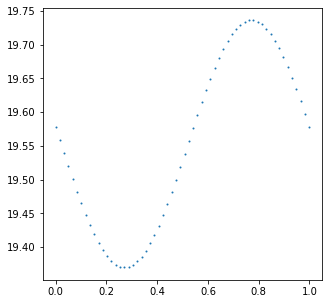

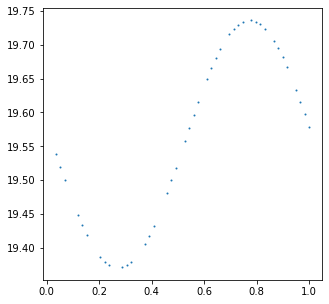

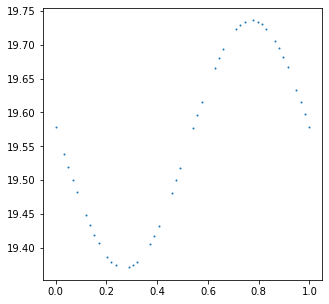

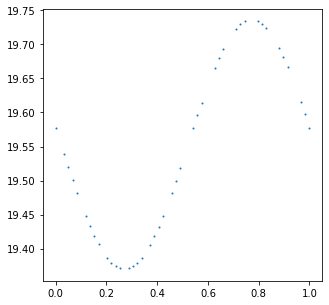

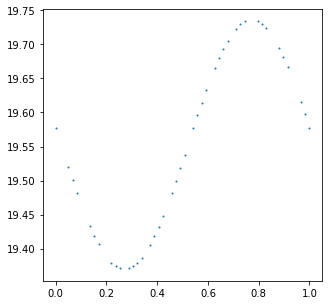

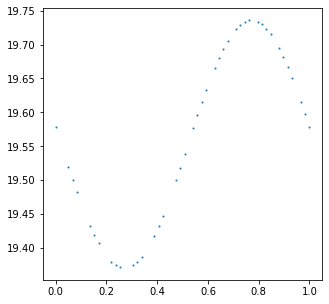

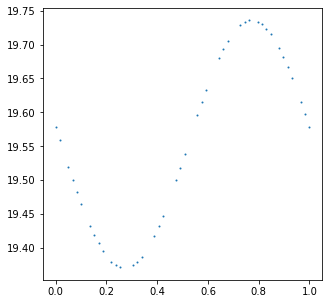

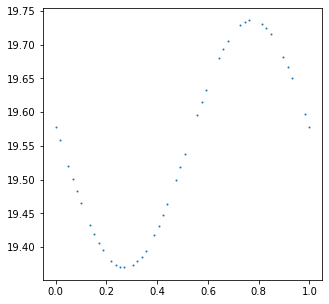

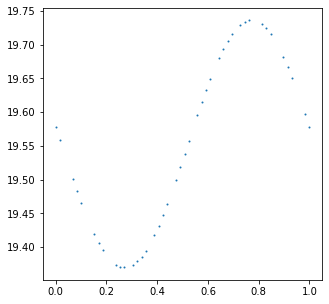

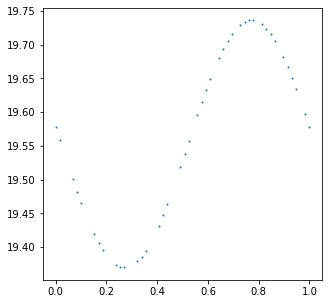

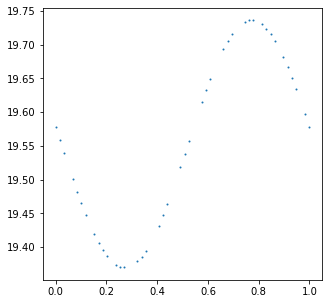

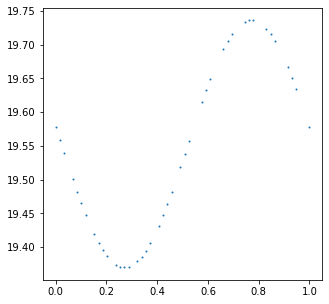

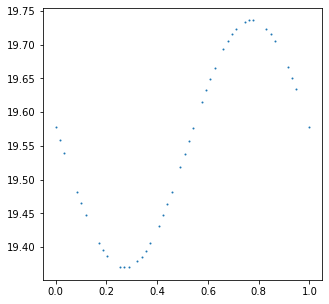

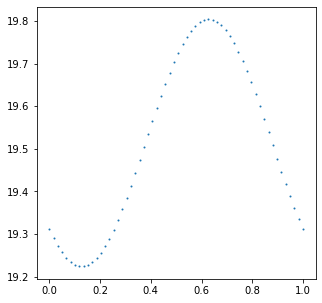

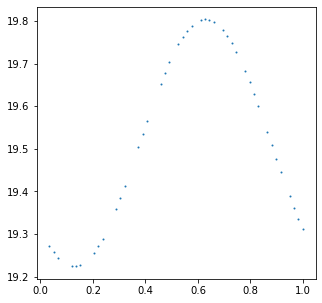

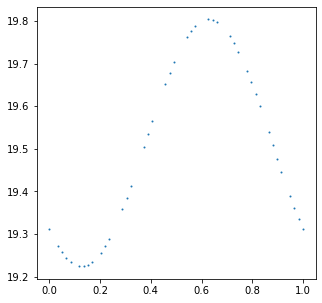

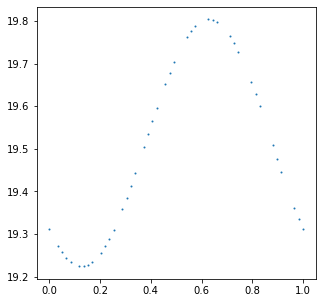

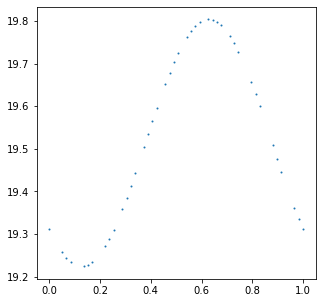

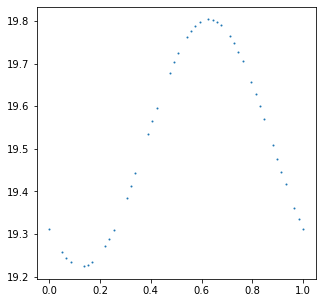

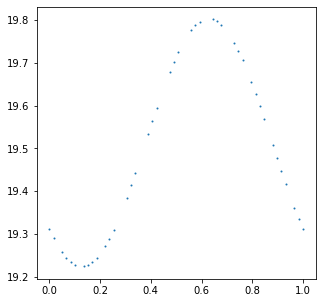

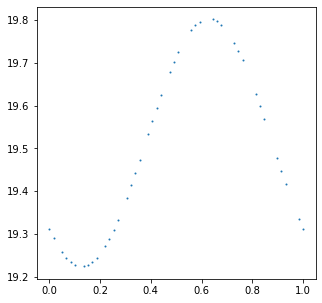

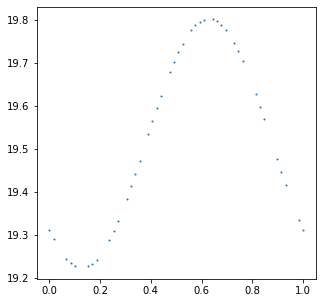

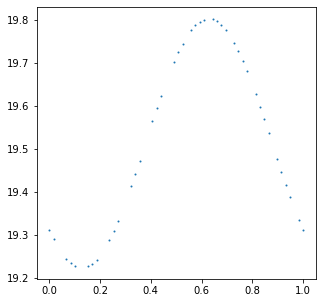

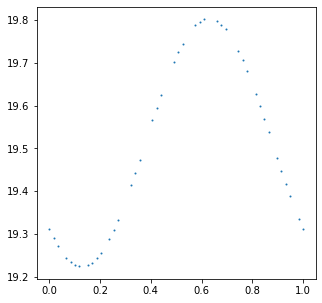

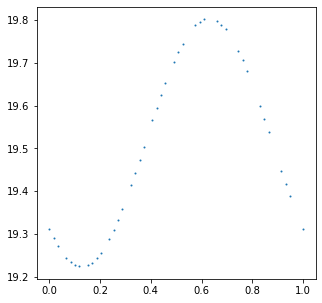

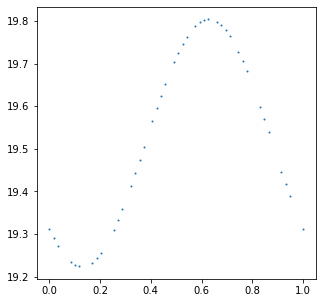

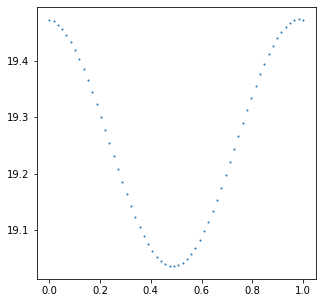

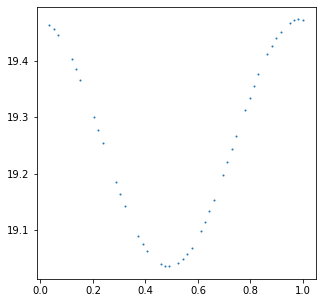

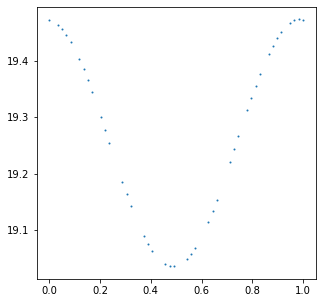

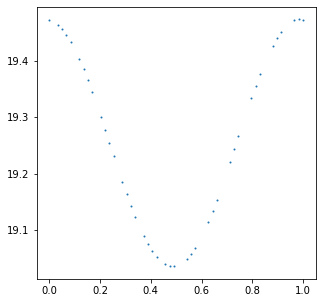

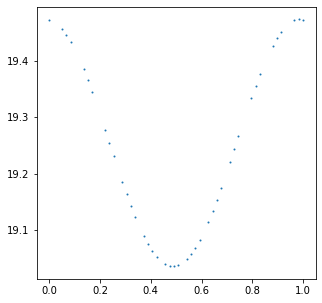

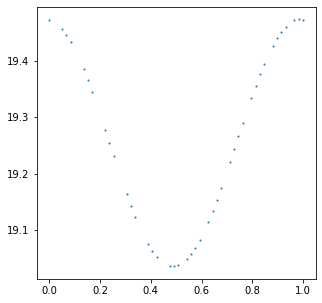

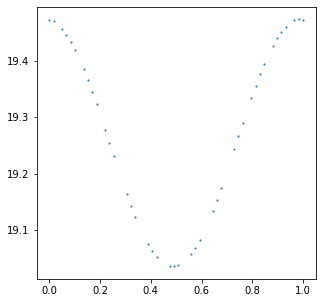

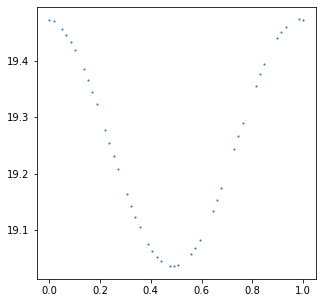

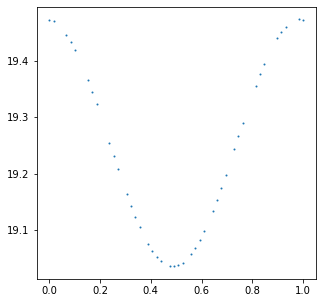

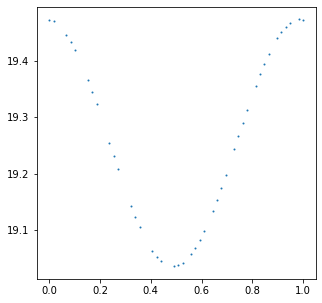

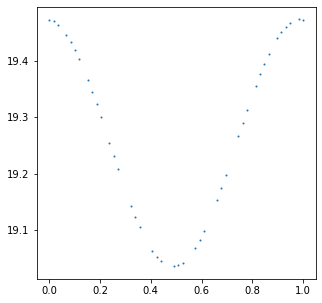

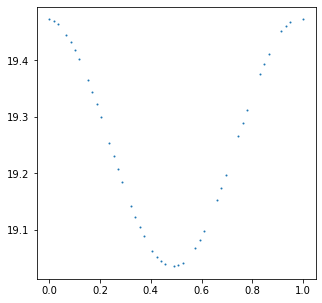

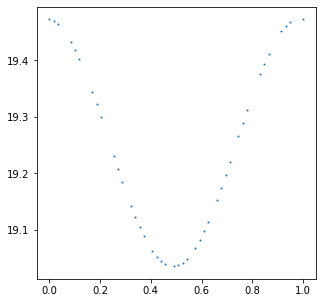

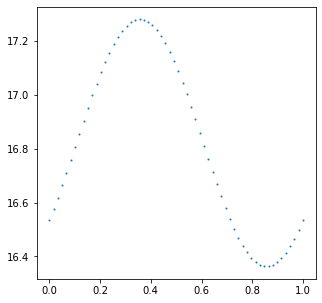

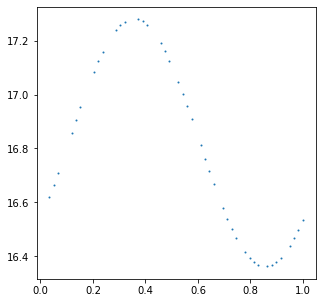

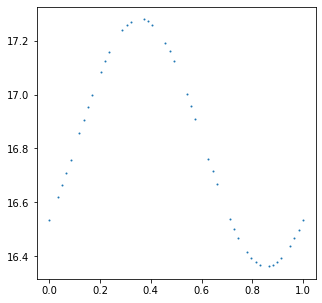

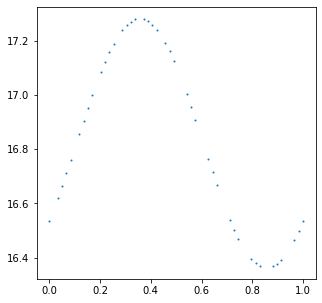

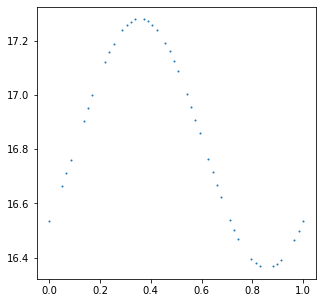

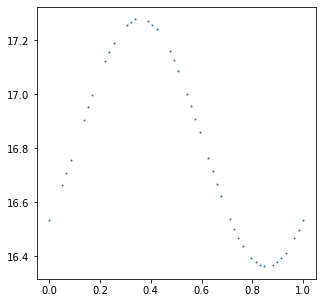

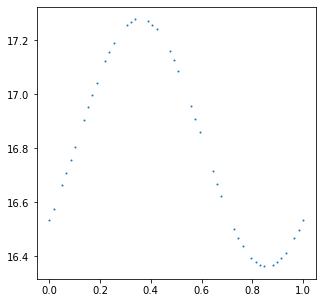

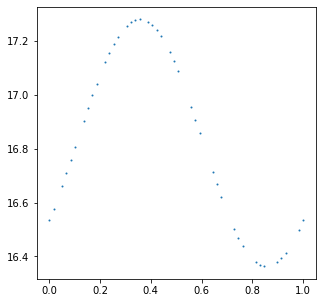

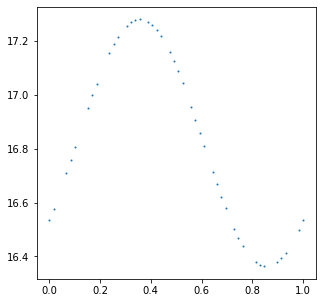

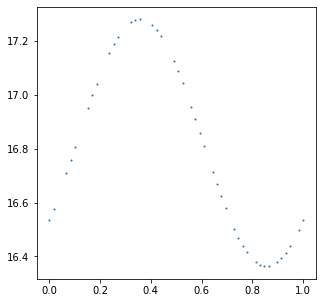

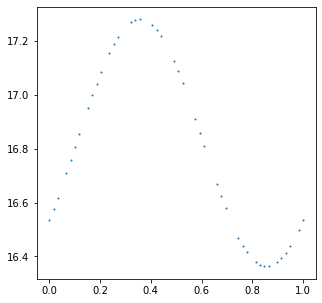

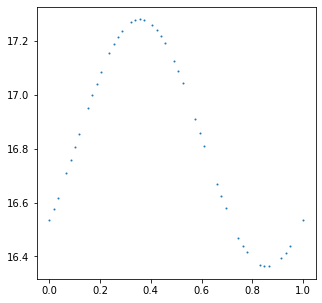

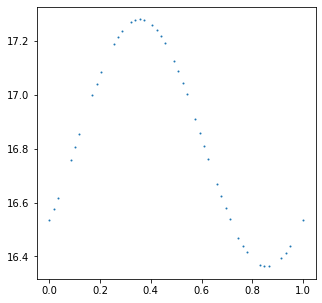

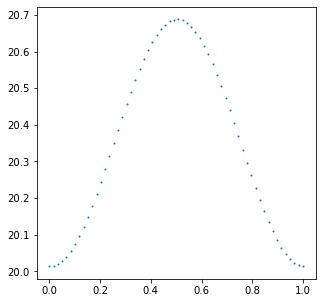

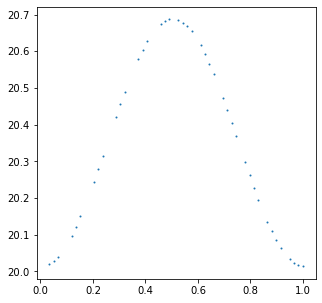

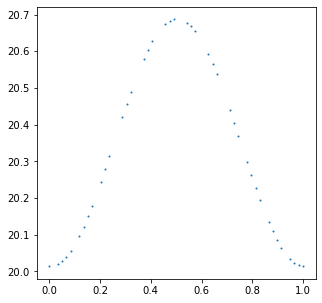

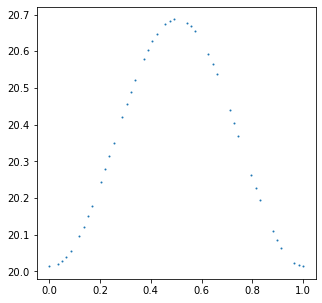

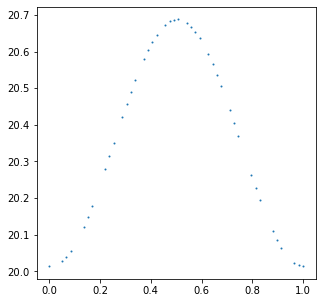

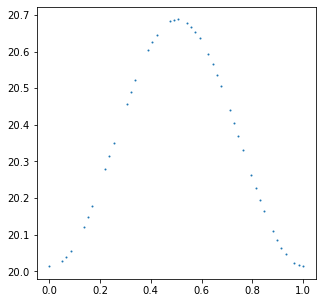

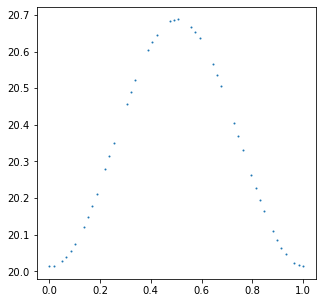

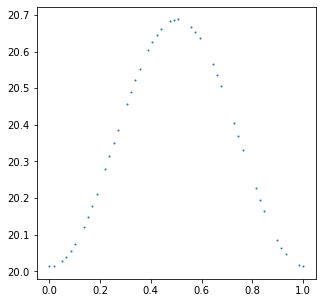

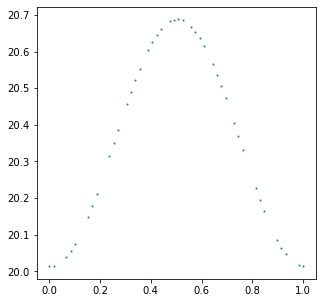

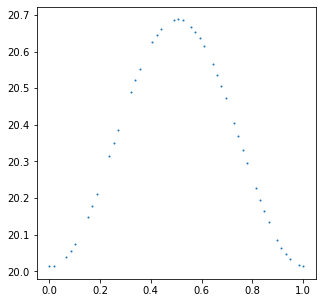

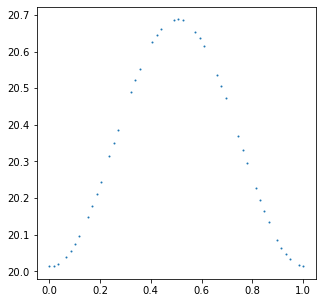

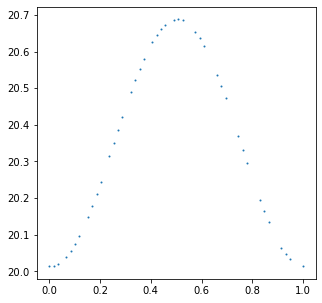

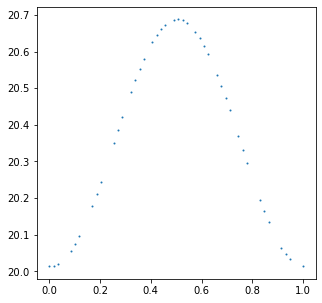

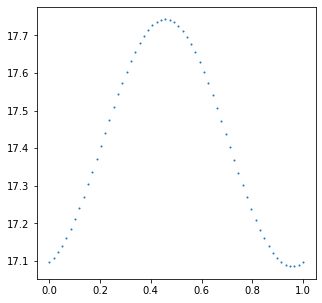

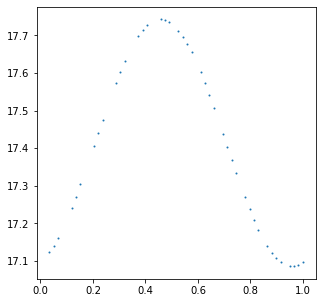

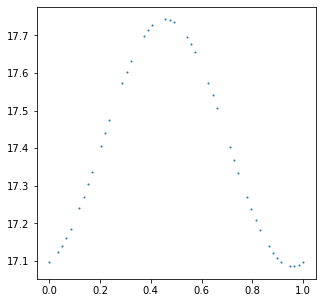

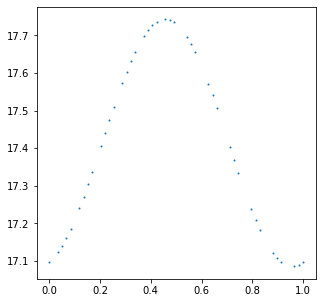

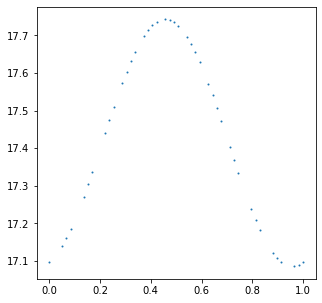

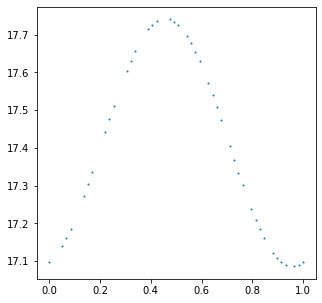

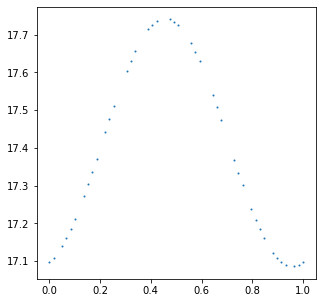

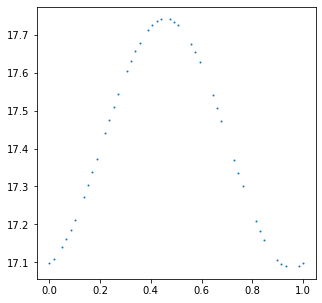

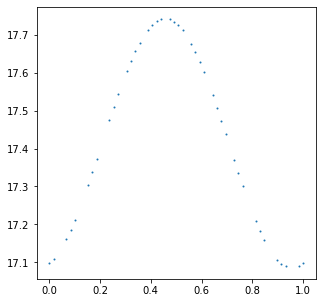

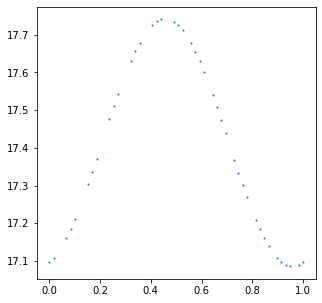

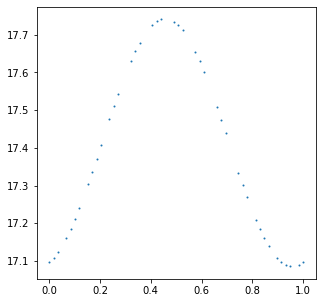

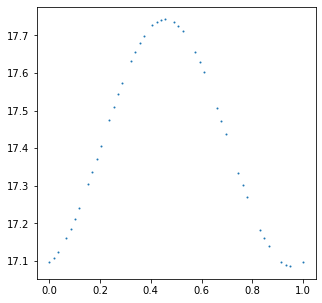

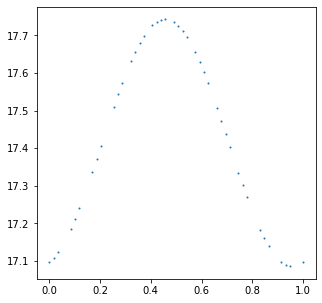

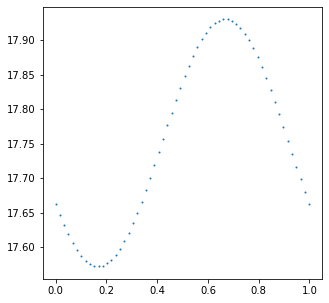

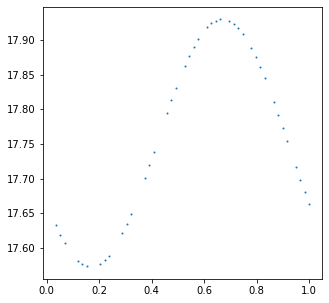

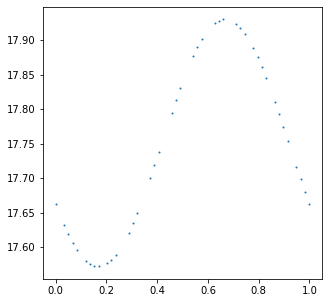

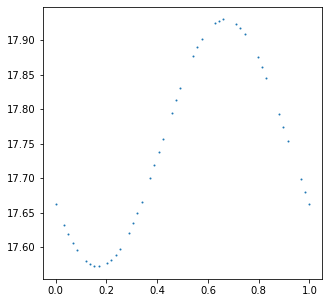

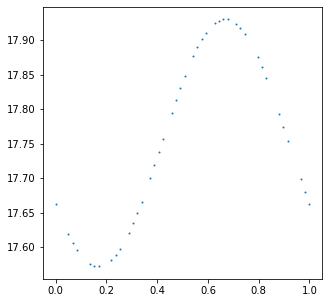

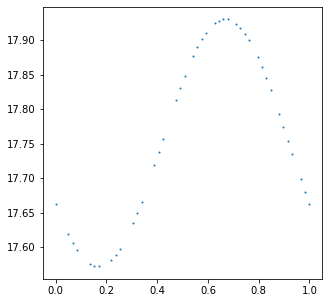

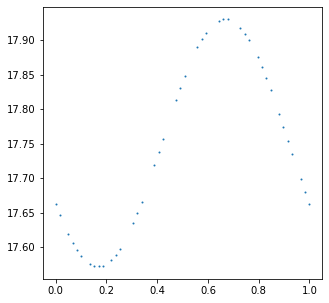

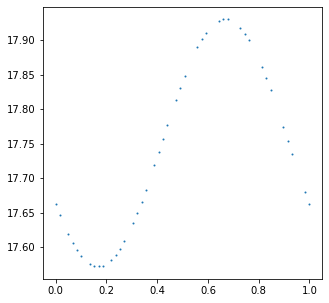

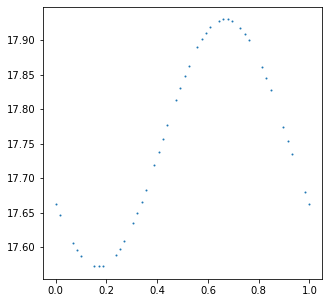

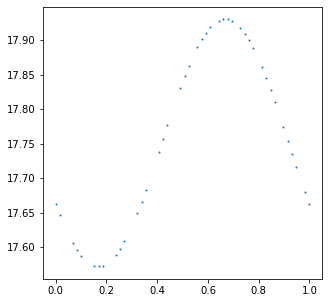

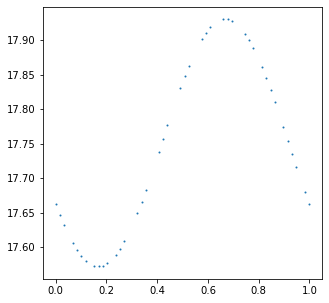

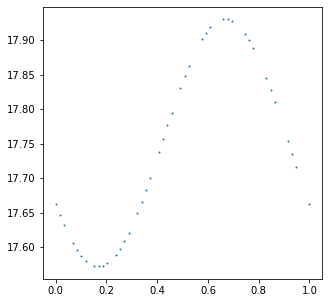

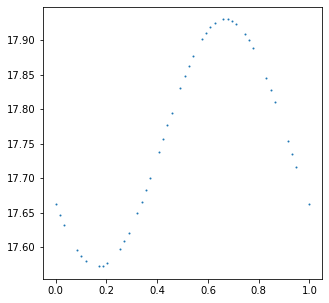

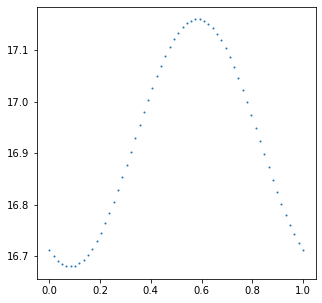

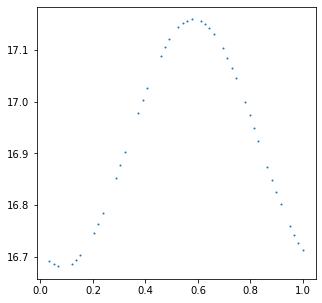

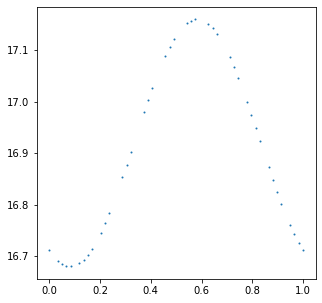

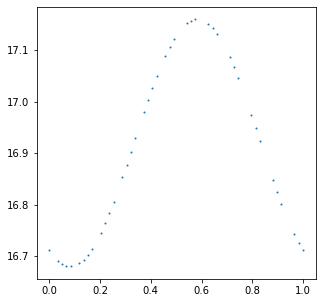

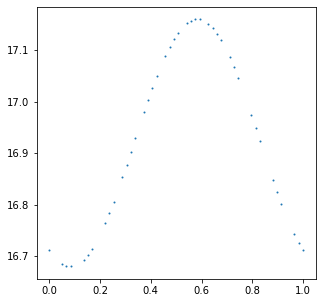

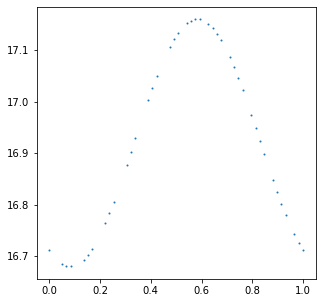

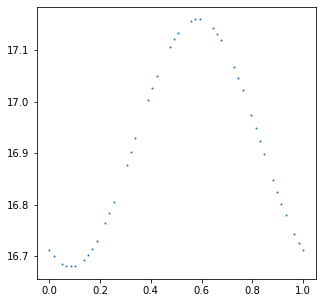

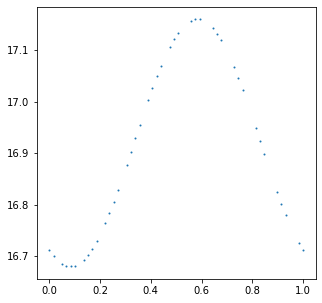

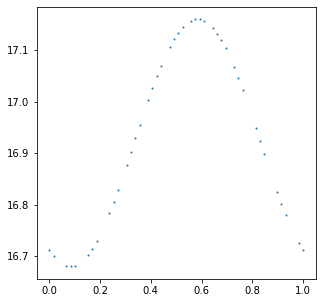

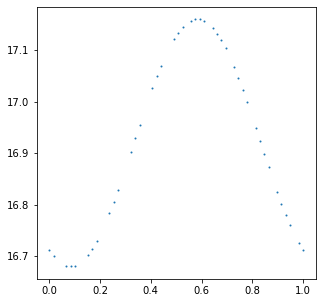

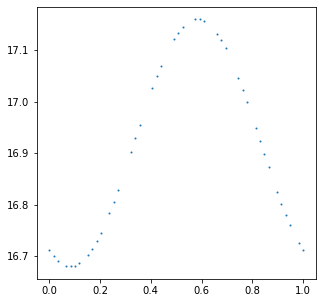

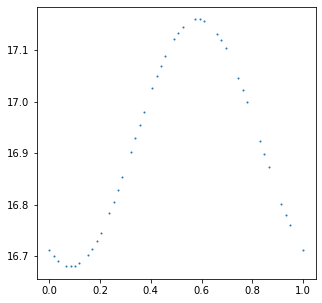

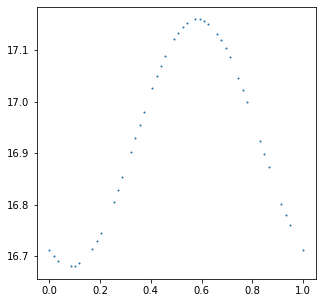

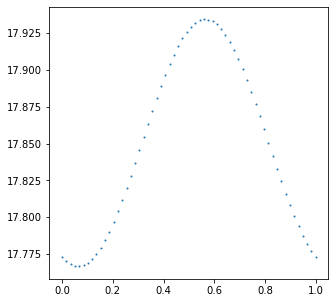

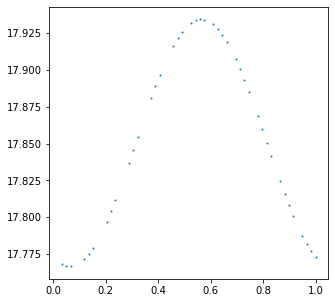

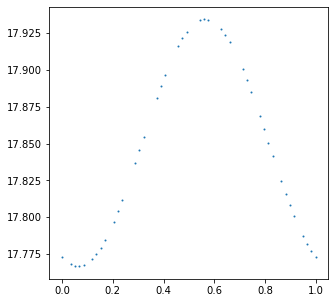

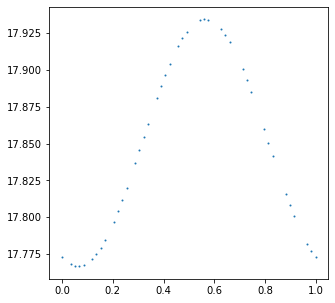

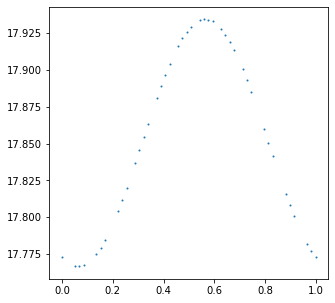

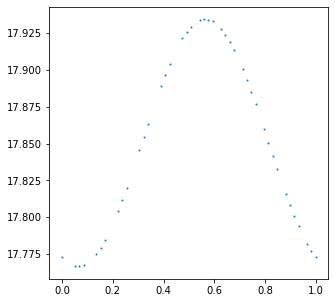

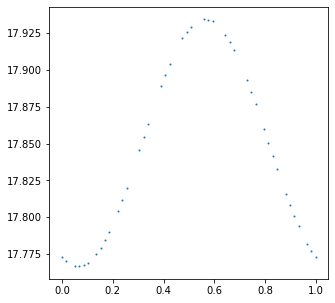

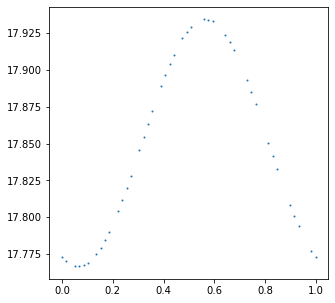

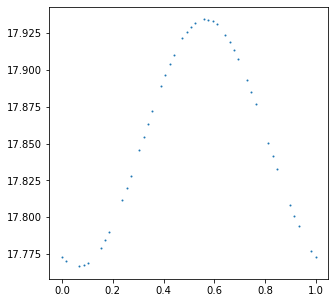

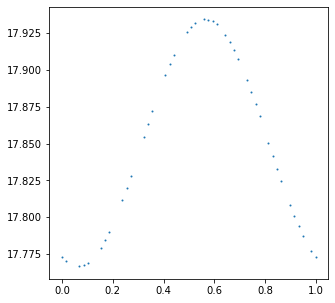

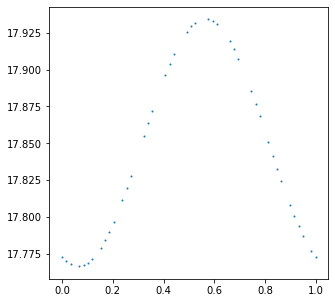

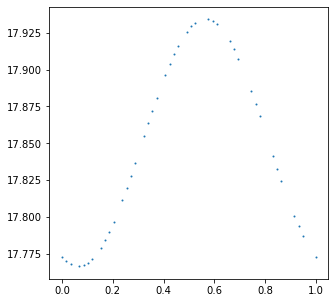

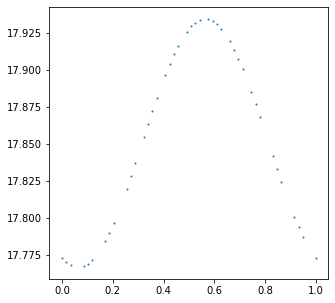

In [77]:
libraryShort=libraryShort.apply(lambda row:determinePeriod(row,
                                                           plot=True), 
                                                           axis=1, result_type='expand')

In [51]:
libraryShort

,_best_period,unique_filts_,ymean_by_filt_,omega,theta,source_id,Expected,E-C,Type,Subtype,Nterms,detectedPeriod,diffPeriod
0,0.236720,"[zg, zi]","[21.48676699, 18.7078934]",26.542730,"[0.00513976, 0.21720297, 0.09356054, -0.013740...",2163969347391329408,0.538431,0.301711,RR,fundamental mode,1,0.236751,-0.000032
1,113.361706,"[zg, zr]","[19.47585281, 15.9530296]",0.055426,"[0.07714091, -0.18145219, 0.02491756, -0.07214...",4068080700794544000,146.171133,32.809427,MIRA_SR,Mira or Semiregular,1,113.376823,-0.015117
2,70.461748,"[zg, zr]","[19.31496061, 15.94673461]",0.089172,"[0.19851974, -0.20921135, -0.20103493, -0.0867...",4068074069364824064,72.297616,1.835867,MIRA_SR,Mira or Semiregular,1,70.471144,-0.009396
3,0.664768,"[zi, zr]","[19.2131386, 20.28765675]",9.451700,"[0.04120764, -0.01789527, 0.21846307, 0.025405...",2167254550695165056,0.698121,0.033353,RR,fundamental mode,1,0.664856,-0.000089
4,0.555125,"[zg, zr]","[16.75914552, 16.15382336]",11.318498,"[0.06246225, 0.35994573, -0.28540377, -0.01781...",146608674289675264,0.555147,0.000021,RR,fundamental mode,1,0.555199,-0.000074
5,0.548941,[zr],[20.23042963],11.446014,"[0.12026205, -0.00885646002, -0.337300463, 4.1...",936935192794009728,0.388228,-0.160713,RR,fundamental mode,1,0.549014,-0.000073
6,0.593826,"[zg, zr]","[17.33795232, 16.55951911]",10.580844,"[0.07589434, 0.08770548, -0.31679578, 0.023850...",48014508850732032,0.593771,-0.000056,RR,fundamental mode,1,0.593906,-0.000079
7,65.361650,"[zg, zr]","[17.73249155, 15.2587256]",0.096130,"[0.01862417, -0.15578503, -0.08795111, 0.03434...",4148779051825804544,147.930423,82.568773,MIRA_SR,Mira or Semiregular,1,65.370366,-0.008716
8,0.627570,"[zg, zr]","[16.91385301, 16.13226967]",10.011932,"[0.00620292, -0.11998438, -0.20789766, -0.0029...",145250128890948352,0.627514,-0.000056,RR,fundamental mode,1,0.627653,-0.000084
9,106.605389,[zr],[17.90674644],0.058939,"[-0.0563268985, -0.0328409153, -0.0772271817, ...",4062151348156107904,143.055223,36.449834,MIRA_SR,Mira or Semiregular,1,106.619605,-0.014216


In [66]:
t=np.linspace(0,10,60)
t2=np.delete(t,np.array(range(5,5+int(len(t)*0.3))))

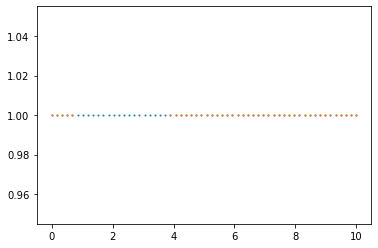

In [67]:
plt.scatter(t,[1]*len(t),s=1)
plt.scatter(t2,[1]*len(t2),s=1)

In [ ]:
libraryShort['detectedPeriod']=libraryShort.apply(lambda row:determinePeriod(row,
                                                                                   plot=True), 
                                                                                   axis=1)
libraryShort['diffPeriod']=libraryShort['_best_period']-libraryShort['detectedPeriod']